# Sentiment analysis

This notebook describes the sentiment analysis steps that were undertaken. In the first part, we extract the sentiment of each quotes. In the second, we provide some descriptive statistics of the final dataset. After that, we go answering our research questions.

## Setup

In [1]:
# Built-in
import os
from IPython.display import display

# Third parties
import numpy as np
import pandas as pd
import nltk
from nltk import tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
# Initialization needed for some modules

# tqdm for pandas
tqdm.pandas()

# NLTK configuration
nltk.download('vader_lexicon')
nltk.download('stopwords')
sia = SentimentIntensityAnalyzer()

# TokenSpace initialization
tokenSpace = tokenize.WhitespaceTokenizer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/AndreasPlesner/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AndreasPlesner/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Configuration
DATA_PATH = "data"
PKL_PATH = os.path.join(DATA_PATH, "pkl")
CSV_PATH = os.path.join(DATA_PATH, "csv")
RESOURCES_PATH = os.path.join(DATA_PATH, "resources")

In [4]:
# Utils functions

def get_sentiment(row: pd.Series) -> pd.Series:
    """
    Compute the sentiment score of a given row
    """   
    
    row['NLTK_score'] = sia.polarity_scores(row['quotation'])
    return row

def counter(text, columnText, quantity, label):
    allWords = ' '.join([text for text in text[columnText].astype('str')])
    tokenPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenPhrase) 
    dfFrequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())}) 
    
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(15,3))
    ax = sns.barplot(data = dfFrequency, x = "Word", y = "Frequency", palette="deep")
    ax.set(ylabel = "Count")
    plt.xticks(rotation='horizontal')
    plt.title(f"Most common words for {label}")
    plt.show()

## 1. Compute sentiment score

Since we have all our extracted mentions dataset, we will simply load each year and create a final aggregated dataframe, since it is not too big (around 100k quotes).

In [5]:
df_lst = []

mentions = [os.path.join(CSV_PATH, f"20{i:02d}_mentions.csv") for i in range(15, 21)]  

for mention in mentions:
    df_mention = pd.read_csv(mention)
    df_lst.append(df_mention)

# Concatenate every year together
df = pd.concat(df_lst) 

In a first place we'll use the Natural Language ToolKit (NLTK) package to do our sentiment analysis. It is using a rules-based approach which assigns to given words a specific sentiment rating which can be neutral, positive or negative (and its compound result). This is a pretty basic approach to scoring the sentiment of sentences but has the advantage of being easily applied and computed very fast.

In [6]:
# Compute the sentiment score
df = df.progress_apply(get_sentiment, axis=1)
    

Remove NLTK columns

In [7]:
NLTK_cols = [col for col in df.columns if 'NLTK' in col]
if len(NLTK_cols) > 0:
    df = df.drop(NLTK_cols, axis=1)

In [8]:
# Sanity check
df.sample(2)

In [9]:
if not os.path.exists(os.path.join(PKL_PATH, 'final_subset.pkl')):
    # Save the final dataframe both in csv and pickle
    df.to_pickle(os.path.join(PKL_PATH, "final_subset.pkl"))
    # df.to_csv(os.path.join(CSV_PATH, "final_subset.csv"))

Now that we have our final subset, we can conduct our exploratory data analysis on it.

## 2. Descriptive statistics

We will now perform some preliminary analysis, having in mind that we want to analyze the evolution of the sentiment scores accross time. We simply explore the data we have to deal with. We look at it in an aggregated way, not separated by party.

In [10]:
# To avoid running the above cells, we load the dataframe directly
# either from csv or pickle
df = pd.read_pickle(os.path.join(PKL_PATH, "final_subset.pkl"))

## For windows users :
# from pickle5 import pickle
# with open("data/pkl/final_subset.pkl", "rb") as fh:
#   df = pickle.load(fh)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105929 entries, 0 to 6361
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            105929 non-null  int64  
 1   quoteID               105929 non-null  object 
 2   quotation             105929 non-null  object 
 3   speaker               105929 non-null  object 
 4   qids                  105929 non-null  object 
 5   date                  105929 non-null  object 
 6   numOccurrences        105929 non-null  float64
 7   probas                105929 non-null  object 
 8   urls                  105929 non-null  object 
 9   phase                 105929 non-null  object 
 10  subset                105929 non-null  bool   
 11  id                    82439 non-null   object 
 12  givenName             105929 non-null  object 
 13  familyName            105929 non-null  object 
 14  unaccentedGivenName   105929 non-null  object 
 15  un

We see that we have many columns (32!). We decided to keep everything for now, as we might need something. We will scrap some information later on.

In [12]:
df.sample(2)

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,nickName,honorificPrefix,honorificSuffix,position,stateName,parties,neg,neu,pos,compound
7223,25054,2016-09-28-025927,for 90 minutes... i watched her -- she was stu...,donald trump,"['Q22686', 'Q27947481']",2016-09-28 01:31:11,1.0,"[['Donald Trump', '0.8236'], ['None', '0.1764']]",['http://nbcnews.com/politics/2016-election/tr...,E,...,NaN,NaN,NaN,President,NaN,Republican,0.101,0.851,0.048,-0.4019
10955,671491,2017-03-24-019390,despite changes made to the republican bill to...,alma adams,['Q4733597'],2017-03-24 07:48:33,1.0,"[['Alma Adams', '0.8644'], ['None', '0.1356']]",['https://insurancenewsnet.com/oarticle/on-the...,E,...,NaN,NaN,NaN,Representative,NC,Democrat,0.255,0.745,0.000,-0.8625


Here we see what a small sample of the data looks like.

In [13]:
print("Unique speakers count: ", len(df["speaker"].unique()))

Unique speakers count:  776


This count (776) unique speakers means that not every politician included in the congress biography list was quoted. We should also keep in mind that those are not truly "unique" speakers, since we currently have aliases for Donald Trump. In the future, we will have many more aliases for many of the speaker. Those aliases will be extracted using the `speaker_attributes` file.


In [14]:
trump_aliases = df[df["speaker"].str.contains("trump")]["speaker"].unique()
print("Number of current aliases for Trump: ", len(trump_aliases))
trump_aliases

Number of current aliases for Trump:  3


array(['donald trump', 'president trump', 'president donald trump'],
      dtype=object)

Next, we are interested about the sentiment scores.

In [15]:
sent_lst = ["neg", "neu", "pos", "compound"]
df[sent_lst].describe()

,neg,neu,pos,compound
count,105929.000000,105929.000000,105929.000000,105929.000000
mean,0.085498,0.817413,0.097087,0.046842
std,0.101861,0.127413,0.100218,0.515874
min,0.000000,0.133000,0.000000,-0.996500
25%,0.000000,0.735000,0.000000,-0.361200
50%,0.058000,0.822000,0.081000,0.000000
75%,0.140000,0.909000,0.155000,0.458800
max,0.835000,1.000000,0.756000,0.999000


For our analysis, we decided to only use the `compound` score, as it is the normalized final score of each separate score.
As we can see, most quotes are scored as "neutral". The median is perfectly at 0 and the mean is very similar. Below is the distribution illustrated:

Text(0, 0.5, 'count')

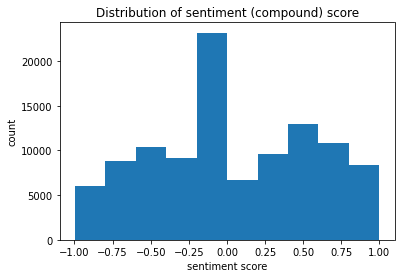

In [16]:
plt.hist(df["compound"])
plt.title("Distribution of sentiment (compound) score")
plt.xlabel("sentiment score")
plt.ylabel("count")

What about its evolution accross time?

In [17]:
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

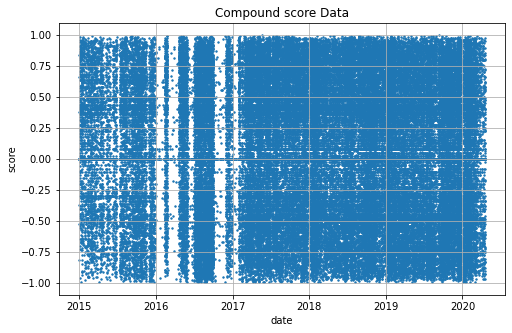

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df["date"], df["compound"], s=2)

# Same as above
ax.set_xlabel('date')
ax.set_ylabel('score')
ax.set_title('Compound score Data')
ax.grid(True)

From what we visually see, there seems to be dates with almost no quotes before 2017. This probably comes from the quotebank dataset itself. We will need to keep that in mind when doing our analysis.

To further see if there is a trend with the compound score, we will compute the average per day.

In [20]:
# Date is currently precise to the second, but we simply want the date
df["date_simp"] = pd.DatetimeIndex(df['date']).normalize()

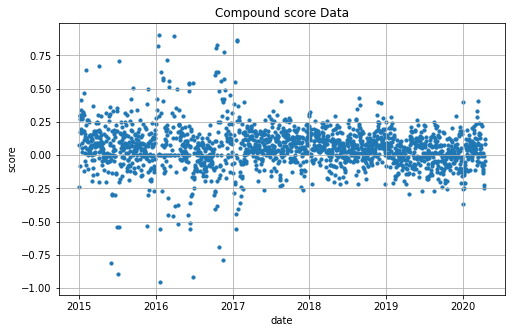

In [21]:
# Plot the average for each day
by_date = df.groupby(["date_simp"])["compound"].mean()

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(by_date.index, by_date, s=10)
ax.set_xlabel('date')
ax.set_ylabel('score')
ax.set_title('Compound score Data')
ax.grid(True)

With the aggregated data, we don't seem to see a trend (maybe a downward trend?). We do see, however, that the variance seem to be higher before 2017. Again, it is clear that this effect comes, in part, from the fact that some days seem to be missing.

We will now further analyze the dataset by exploring different things per party.

## 3. Sentiment analysis

In [22]:
# Split the df by party
party_grps = df.groupby('parties')
df_rep = df[df["parties"] == "Republican"]
df_dem = df[df["parties"] == "Democrat"]

In [23]:
for party, grp in party_grps:
    print(f'Number of {party} quotes: {len(grp)}')

Number of Democrat quotes: 49672
Number of Republican quotes: 56257


### 3.1 Quotes sentiment for each party (using NLTK)

The following distributions show the amount of quotes categorized in each sentiment categories (neutral, negative, positive). The axis represent the amount of certainty a quote is to be categorized as such. Therefore, quotes on the left side of the graph are uncertainly classified as its type while quotes on the right are highly likely to be classified in the right type, according to our sentiment analysis classifier. <br>

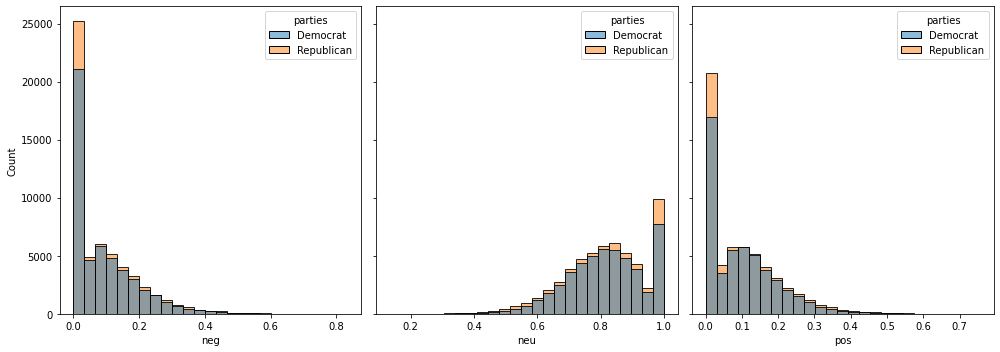

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(14,5), sharey=True)
sns.histplot(data=df, x='neg', hue='parties', ax=axes[0], bins=25)
sns.histplot(data=df, x='neu', hue='parties', ax=axes[1], bins=25)
sns.histplot(data=df, x='pos', hue='parties', ax=axes[2], bins=25)
fig.tight_layout()

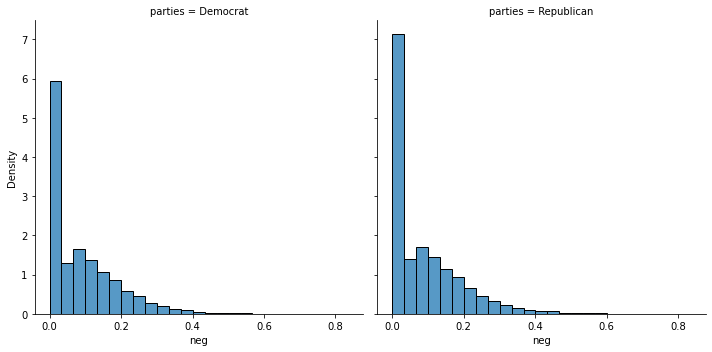

In [25]:
sns.displot(data=df, x='neg', stat='density', col='parties', bins=25, kind='hist', col_wrap=2);


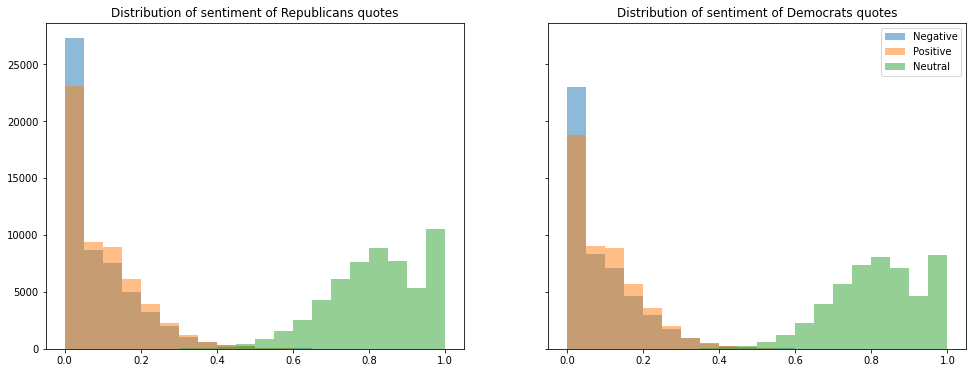

In [26]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16.5,6))
# Overall distribution of republicans quotes sentiment
labels = ['neg','pos', 'neu']
axes[0].hist(df_rep['neg'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[0].hist(df_rep['pos'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[0].hist(df_rep['neu'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[0].set_title('Distribution of sentiment of Republicans quotes')
axes[1].hist(df_dem['neg'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[1].hist(df_dem['pos'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[1].hist(df_dem['neu'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
labels = ['Negative','Positive', 'Neutral']
axes[1].set_title('Distribution of sentiment of Democrats quotes')
plt.legend(labels);

In [27]:
for name, value in zip(['Compound', 'Negative', 'Neutral', 'Positive'], ['compound', 'neg', 'neu', 'pos']):
    print(name)
    display(party_grps[value].describe())
    print(scipy.stats.ttest_ind(party_grps.get_group('Democrat')[value], party_grps.get_group('Republican')[value]))
    print('')

Compound


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.049648,0.518496,-0.9958,-0.3612,0.0,0.4767,0.9990
Republican,56257.0,0.044364,0.513539,-0.9965,-0.3612,0.0,0.4522,0.9989


Ttest_indResult(statistic=1.6638992520114593, pvalue=0.09613552248150549)

Negative


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.085746,0.099209,0.0,0.0,0.061,0.14025,0.737
Republican,56257.0,0.085280,0.104146,0.0,0.0,0.055,0.14000,0.835


Ttest_indResult(statistic=0.7428796097784959, pvalue=0.4575562190165472)

Neutral


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.816635,0.123868,0.133,0.735,0.820,0.904,1.0
Republican,56257.0,0.818099,0.130460,0.165,0.734,0.824,0.913,1.0


Ttest_indResult(statistic=-1.8662805000581908, pvalue=0.06200489271517315)

Positive


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.097616,0.097041,0.0,0.0,0.085,0.155,0.756
Republican,56257.0,0.096620,0.102940,0.0,0.0,0.077,0.156,0.737


Ttest_indResult(statistic=1.6139935028982755, pvalue=0.10653181416833096)



Not all quotes that where pos > neg have a positive compound nor is the opposite true

In [83]:
df = df.assign(
    pos_sentiment=lambda x: x.neg <= x.pos, 
    days_since_start=lambda x: (x.date_simp - df.date_simp.min()).dt.total_seconds()/(24*60*60)
)
df = df.assign(compound_check= lambda x: x.pos_sentiment == (x.compound >= 0))
display(df[df['compound_check'] == False].sample(5))
df['compound_check'].value_counts()

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,stateName,parties,neg,neu,pos,compound,date_simp,pos_sentiment,days_since_start,compound_check
9917,375930,2015-02-13-037528,if there is a successful attack during a dhs s...,mark kirk,['Q339046'],2015-02-13 04:21:54,1.0,"[['Mark Kirk', '0.9433'], ['None', '0.0567']]",['http://dailycaller.com/2015/02/12/gop-senate...,E,...,IL,Republican,0.196,0.608,0.196,-0.2500,2015-02-13,True,43.0,False
54002,541394,2018-10-22-046027,"if we fail to act swiftly, i fear as the 2020 ...",earl blumenauer,['Q748066'],2018-10-22 06:17:53,2.0,"[['Earl Blumenauer', '0.9063'], ['None', '0.08...",['https://stopthedrugwar.org/chronicle/2018/oc...,E,...,OR,Democrat,0.142,0.699,0.159,-0.0516,2018-10-22,True,1390.0,False
68267,457061,2018-05-10-085979,"most americans... what they're saying is, `we ...",mark meadows,"['Q3956796', 'Q6768847', 'Q6768848']",2018-05-10 08:30:00,7.0,"[['Mark Meadows', '0.8957'], ['None', '0.0866'...",['https://www.heraldnet.com/nation-world/gop-c...,E,...,NC,Republican,0.101,0.782,0.117,-0.0258,2018-05-10,True,1225.0,False
70651,621772,2018-03-09-102330,republicans want illegal immigrants to work bu...,dean heller,['Q251763'],2018-03-09 09:45:28,2.0,"[['Dean Heller', '0.7106'], ['None', '0.2895']]",['https://thinkprogress.org/nevada-senator-dem...,E,...,NV,Republican,0.092,0.803,0.104,-0.1779,2018-03-09,True,1163.0,False
89823,176182,2019-01-31-023293,"fight to regain democracy,' as.. credit: wochi...",donald trump,"['Q22686', 'Q27947481']",2019-01-31 06:47:11,1.0,"[['Donald Trump', '0.9073'], ['None', '0.0663'...",['http://onenewspage.com/n/Politics/1zkg363bsh...,E,...,NaN,Republican,0.058,0.884,0.058,-0.2263,2019-01-31,True,1491.0,False


True     104302
False      1627
Name: compound_check, dtype: int64

We can see that there are a lot of quotes classified as having a certainly neutral tone while the ones with a positive or negative tone are of small certainty. <br>
There seems to be overall a bit more negatively assigned quotes rather than positively, and that republicans have overall been more often critics of the opponent party than the democrats.

Next, we'll look at the compound sentiment value for each party accross each year of interest.

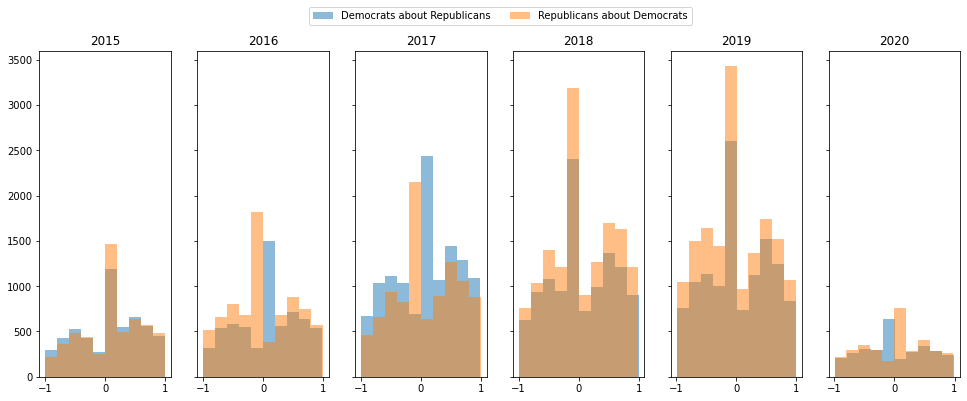

In [29]:
year = 2015
fig, axes = plt.subplots(1, 6, sharey=True, figsize=(16.5,6))
for i in range(0,6):
    axes[i].hist(df_dem[df_dem['date'].astype(str).str.contains(f"{year}")]['compound'], alpha = 0.5, label ="Democrats about Republicans");
    axes[i].hist(df_rep[df_rep['date'].astype(str).str.contains(f"{year}")]['compound'], alpha=0.5, label ="Republicans about Democrats");
    axes[i].set_title(f"{year}");
    year += 1
axes[0].legend(bbox_to_anchor =(5, 1.15), ncol = 2)

The various distributions of quotes sentiment scores over each year show us 2 things. <br>
First, except for the year 2020 (for which we lack data), there have been more and more quotes coming from either party mentionning the opposition one. <br>
Second, that depending on the year we see different amount of quote mentionning the other party. Indeed, in 2015 the distributions look pretty similar in shape (with the increase); from 2016 to 2019, we've extracted more quotes about republicans mentionning democrats rather than the opposite, except in 2017 where democrats seem to have been more actively speaking about their opponent. This can be explained by the presidential election that occurred in the beggining of this year and the following criticism the newly president may have faced (especially with his controversial ideas about Muslim-majority nations travel ban, Mexico wall..). <br>
We'll later dive deeper in this direction and check the consequence on these distributions of specific events.

### 3.2 Most common words analysis

Here we take a look at the words the most used by each party. 

In [52]:
#remove and keep some of the stopwords
stop = stopwords.words("english")

# Add to the stopword list common words an punctuation that is present for both emotions
stop = stop + ["going", "would", "want", "get", "one", "-", "_", "[", "]"]

df_rep = df_rep.assign(qoutation_clean=df_rep["quotation"].apply(lambda x: " ".join(x for x in x.split() if x not in stop)))
df_dem = df_dem.assign(qoutation_clean=df_dem["quotation"].apply(lambda x: " ".join(x for x in x.split() if x not in stop)))

These histograms show those most common words after a first sorting where we've removed common english stopwords (mostly determinants, common verbs and punctuation). These words mostly refers to the opponent party title or its leading member. A further investigation by focusing on certain periods or removing even more general terms could reveal more intense words or speach patterns.

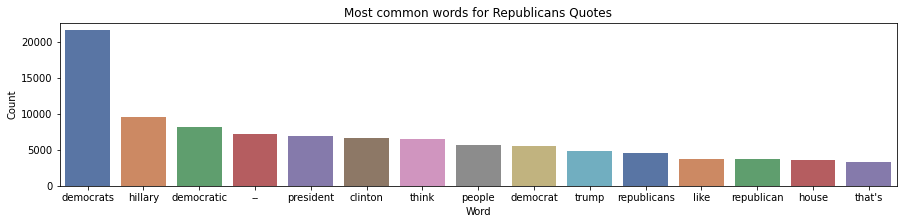

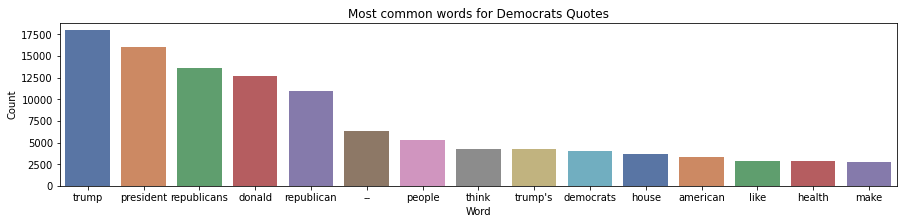

In [53]:
counter(df_rep, 'quotation_clean', 15, 'Republicans Quotes')
counter(df_dem, 'quotation_clean', 15, 'Democrats Quotes')

### 3.3 Regression

In [1]:
# TODO
# Olivier: add regression by year?

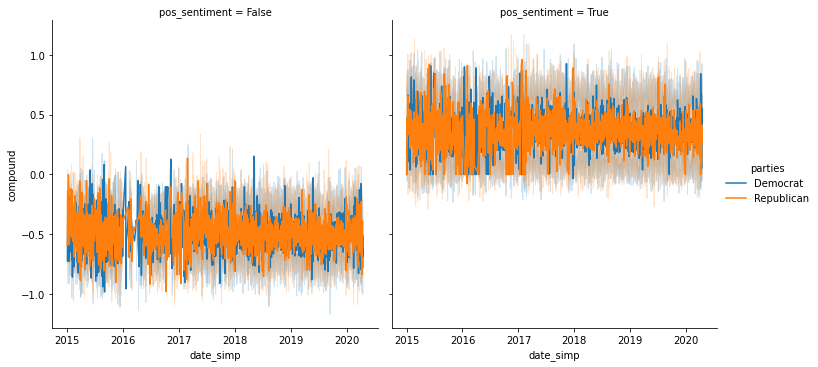

In [32]:
sns.relplot(data=df, x='date_simp', y='compound', hue='parties', kind='line', ci='sd', col='pos_sentiment');

In [85]:
grps = df.groupby(['pos_sentiment', 'parties'])
results = {}
for label, grp in grps:
    res = smf.ols('compound ~ days_since_start', data=grp).fit()
    results[label] = res

In [87]:
for label, res in results.items():
    print(label)
    print(res.summary())

(False, 'Democrat')
                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1095
Date:                Wed, 01 Dec 2021   Prob (F-statistic):              0.741
Time:                        16:43:24   Log-Likelihood:                -1458.4
No. Observations:               18709   AIC:                             2921.
Df Residuals:                   18707   BIC:                             2936.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           

### 3.4 Aggressivity by speaker analysis

This section answers the question: "Which politicians are the least or the most aggressive?". We should strongly emphasize the fact that we consider a politician as being "aggressive" if she or he has an overall negative sentiment score, which is quite a shortcut. Unfortunately, the scope of the project did not allow us to provide a semantic analysis of the quotes to see if a negative quote also means, on average, that the vocabulary used and the speaker are more aggressive.

Let us start by simply analyzing the most negative scores for all speakers throughout the whole dataset.

In [28]:
most_agg = df.groupby(["speaker", "parties"]).agg({
    "compound": "mean",
    "speaker": "size", 
}) \
.rename({"speaker": "quotes_count"}, axis=1) \
.sort_values("compound")

most_agg.head(5)

,,compound,quotes_count
speaker,parties,,
robert hayes,Republican,-0.8910,1
david hobson,Republican,-0.7841,1
ron lewis,Republican,-0.7783,1
john shadegg,Republican,-0.7351,1
heath shuler,Democrat,-0.6249,1


As we can see, most extremely negative (and thus aggressive by our methodology) speakers are such because they only have one quote to their names. So we will only consider those with at least 100 quotes.

In [20]:
most_agg = most_agg[most_agg["quotes_count"] >= 100]
# Only keep those really negative
threshold = -0.05
most_agg = most_agg[most_agg["compound"] <= threshold].sort_values("compound")
most_agg

,,compound,quotes_count
speaker,parties,,
barbara lee,Democrat,-0.211459,182
tulsi gabbard,Democrat,-0.139305,332
joe walsh,Republican,-0.096052,105
elijah cummings,Democrat,-0.095461,936
maxine waters,Democrat,-0.090463,480
bennie thompson,Democrat,-0.087981,129
pramila jayapal,Democrat,-0.073166,270
claudia tenney,Republican,-0.070770,117
john yarmuth,Democrat,-0.070638,226


In [21]:
# Compute count and proportion by party
g = pd.DataFrame(most_agg.groupby("parties").size()).rename({0: "count"}, axis=1)
g["proportion"] = g["count"] / g["count"].sum()
g

,count,proportion
parties,,
Democrat,14,0.823529
Republican,3,0.176471


It clearly came as a surprise to us that the democrats seems to be the most aggressive ones when mentioning another politician from the other party. In the next section, we focus on the 3 most aggressive speakers.

#### EDA of most aggressive speakers

It seems that the following speakers are specifically negative and thus, polarizing when they are mentioning people of the other political camp:
- [Barbara Lee](https://en.wikipedia.org/wiki/Barbara_Lee) (Democrat)
- [Tulsi Gabbard](https://en.wikipedia.org/wiki/Tulsi_Gabbard) (Democrat)
- [Joe Walsh](https://en.wikipedia.org/wiki/Joe_Walsh_(Illinois_politician)) (Republican)

To explore that, let us explore a few random quotes from them.

In [12]:
speakers = ["barbara lee", "tulsi gabbard", "joe walsh"]

for speaker in speakers:
    print("Samples from", speaker)
    quotes = df[df["speaker"] == speaker].sample(3)[["quoteID", "compound", "quotation"]].values
    for q in quotes:
        print(f"QID: {q[0]}, Score: {q[1]} \n \"{q[-1]}\"\n")
    print("-" * 30)

Sample from barbara lee
QID: 2018-11-06-063279, Score: 0.0516 
 "last month, when asked about his budget-busting tax gift to the wealthy, the republican senate majority leader (mitch mcconnell) told bloomberg news that his `single biggest disappointment' in his career had been his failure to gut medicare and social security,"

QID: 2017-03-10-024778, Score: -0.8176 
 "for more than fifteen years, the u.s. has been engaged in an ever-expanding war in the middle east. president trump's deployment of combat troops in syria is the latest front in this endless war."

QID: 2017-10-07-058395, Score: 0.3527 
 "remember president trump said `what do we have to lose?' to the black community? well, we answered him and sent him an entire agenda as it relates to the african american community,"

------------------------------
Sample from tulsi gabbard
QID: 2017-12-06-098842, Score: 0.8555 
 "our telephone townhall was an important opportunity to share the facts about what is at stake for the people

By doing that multiple times (we only extracted 3 quotes by politican here), we can observe a few things. First, our method seems to capture well the polarization between the two political camps:
- Tulsi Gabbard (QID: 2019-09-25-056870, Score: -0.3182):
> it's important that donald trump is defeated,
- Barbara Lee (QID: 2015-09-16-064526 Score: -0.743):
> it's past time that republicans stop governing by crisis,
- Joe Walsh (QID: 2019-08-24-040425, Score: -0.3818):
> the truth: as practiced by most muslims, islam is not a religion. these muslims are at war w us. barack obama, a muslim, is on their side,

In some cases, though, this process outlined some clear problems:
- Barbara Lee (QID: 2020-04-16-025948 Score: **0.8074**)
>instead of giving relief to americans who are struggling to make ends meet, senate republicans snuck in tax breaks and corporate giveaways for their wealthy friends,
    - This quote should be negative and is a clear example of polarizing quote. It is not detected as such by our algorithm.
- Tulsi Gabbard (QID: 2019-04-30-091725, Score: -0.4927)
> the most attacks i get are not from republicans,
    - Although she mentions republicans, this quote is actually in favor of them, but is actually _in favor_ of republicans.
    
Those are just some examples that we wanted to outline to show some shortcomings of our algorithm. Those points could be further investigated in future work.

Now that we analyzed the aggressivity in bulk, chapter 3.1 of this notebook indicated that there seems to be a great change through the years. So we now do a similar analysis of the most aggressive speakers per year.


#### Most aggressive speakers by year

By using the same methodology as the previous point, we extract only the most aggressive speakers with at least 100 quotes and with a mean score of at least -0.05.

In [11]:
# create new "year" column in df
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

In [14]:
# Sanity check
df.sample(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,subset,...,honorificSuffix,position,stateName,parties,NLTK score,neg,neu,pos,compound,year
2665,2019-10-22-057060,"just the facts, baby. if we tell that story wi...",hakeem jeffries,['Q5640425'],2019-10-22 13:11:08,3.0,"[['Hakeem Jeffries', '0.9085'], ['None', '0.09...",['https://thefederalist.com/2019/10/22/the-clo...,E,True,...,NaN,Representative,NY,Democrat,"{'neg': 0.048, 'neu': 0.845, 'pos': 0.107, 'co...",0.048,0.845,0.107,0.4404,2019


In [34]:
most_agg = df.groupby(["year", "speaker", "parties"]).agg({
    "compound": "mean",
    "speaker": "size", 
}) \
.rename({"speaker": "quotes_count"}, axis=1) \
.sort_values("compound")

most_agg = most_agg[most_agg["quotes_count"] >= 100]
# Only keep those really negative
threshold = -0.05
most_agg = most_agg[most_agg["compound"] <= threshold].sort_values("year")

In [17]:
# Display table
most_agg

compound  quotes_count
year speaker                  parties                           
2015 elijah cummings          Democrat   -0.339667           201
2016 elijah cummings          Democrat   -0.188794           132
     donald trump             Republican -0.052753          4094
2017 jeff flake               Republican -0.111487           133
     ted lieu                 Democrat   -0.077877           100
     cory booker              Democrat   -0.078286           132
     jeanne shaheen           Democrat   -0.056756           100
     barbara lee              Democrat   -0.232446           104
     kirsten gillibrand       Democrat   -0.074496           156
     maxine waters            Democrat   -0.114713           180
2018 orrin hatch              Republican -0.075000           137
     ted lieu                 Democrat   -0.061465           109
     dianne feinstein         Democrat   -0.083949           318
     mazie hirono             Democrat   -0.119052           102
     kirsten gillibrand       Democrat   -0.120604           140
     maxine waters            Democrat   -0.122643           164
     adam smith               Democrat   -0.054608           106
     jerrold nadler           Democrat   -0.116621           131
     richard blumenthal       Democrat   -0.072185           227
2019 president donald trump   Republican -0.057747          3823
     devin nunes              Republican -0.062832           476
     kamala harris            Democrat   -0.054848           169
     xavier becerra           Democrat   -0.173166           116
     rashida tlaib            Democrat   -0.054251           107
     elise stefanik           Republican -0.097369           157
     mo brooks                Republican -0.120918           171
     tulsi gabbard            Democrat   -0.126019           205
     john ratcliffe           Republican -0.129743           117
     alexandria ocasio-cortez Democrat   -0.082365           279
     donald trump             Republican -0.080294           987

In [37]:
g = pd.DataFrame(most_agg.groupby(["year", "parties"]).size()).rename({0: "count"}, axis=1)
g["proportion"] = g["count"] / g.groupby("year")["count"].sum()
g

count  proportion
year parties                      
2015 Democrat        1    1.000000
2016 Democrat        1    0.500000
     Republican      1    0.500000
2017 Democrat        6    0.857143
     Republican      1    0.142857
2018 Democrat        8    0.888889
     Republican      1    0.111111
2019 Democrat        5    0.454545
     Republican      6    0.545455

The first thing we observe is that we have only one speaker denoted as "aggressive" in 2015. This comes from the fact that we have fewer quotes in earlier year (2015 and 2016, see section 3.1). Also, it appears that we did not have enough data in 2020 to extract meaningful insights. 

In 2017 and 2018, aggressive speakers are overwhelmingly democrats. Only one republican is denoted as aggressive. In 2019, we have an exact parity between democrats and republicans. Indeed, Donald Trump is counted twice, once under "donald trump" and once under "president donald trump". 

From the most aggressive table, we clearly see that something seems to have happened around 2016 (Trump's election?) which seems to have (1) greatly increased the number of quotes about the other camp by politicians and, (2) greatly increased the number of aggressive speakers (democrats in that case). In 2019, republicans **seem to have responded to that aggressivity** by also being aggressive. We will continue to explore the evolution of the score around key events in the next section.  

### 3.5 Evolution of score around key events

_Refer to `events_dataset.ipynb` to see how the events dataset was created._

## Conclusion 